In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# some common packages
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore')  # suppress warnings

# 1.  Pilot Study: check inter-coder reliability

A pilot study with 120 posts was conducted to check the inter-coder reliability.
The sentiment label include -1 (negative), 0 (neutural),  1 (positive) and 2 (irrelevant posts).

In [ ]:
df1 = pd.read_excel('/content/drive/MyDrive/Capstone/Labeled/reddit_comments120_coder1.xlsx')   #rz
df2 = pd.read_excel('/content/drive/MyDrive/Capstone/Labeled/reddit_comments120_coder2.xlsx')   #zj

display(df1.shape, df2.shape)

(120, 4)

(120, 4)

**Recode target variable**

- Option 1: recode 2 as 0, so it is a 3-class task (neg, neutral, pos).
- Option 2: recode 2 and -1 as 0, so it is a binary task (positive vs. non-pos).
- Option 3: recode 2 an 1 as 0, -1 as 1,  so it is a binary task (neg vs. non-neg).

In [ ]:
# define a function

def recode_target(data, option):
  if option == 1:
    data.loc[data['sentiment label'] == 2, 'sentiment label'] = 0
  elif option == 2:
    data.loc[data['sentiment label'].isin([-1,2]), 'sentiment label'] = 0     # simplify as a binary problem (recode -1, 2 as 0)
  else:
    data.loc[data['sentiment label'].isin([1,2]), 'sentiment label'] = 0      # simplify as a binary problem (recode 1, 2 as 0)
    data.loc[data['sentiment label'] == -1, 'sentiment label'] = 1            # recode negative (-1) as 1 (for later model evlauation)
  return data

In [ ]:
option = 1  # 3-class task here

df1 = recode_target(data = df1, option = option)
df2 = recode_target(data = df2, option = option)

**Check Inter-coder Reliability**

The inter-coder reliability is measured by ``cohen's kappa`` score, see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html) for details.

- As we see below, the cohen's kappa score reach 0.76, indicating a substantial agreement between the two coders.

In [ ]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y1= df1['sentiment label'], y2= df2['sentiment label'])

0.7595443999156296

In [ ]:
# count the frequncy for each label
for i in [-1,0,1,2]:
    print("Label" ,i,":", sum(df1['sentiment label']==i), sum(df2['sentiment label']==i))

Label -1 : 43 46
Label 0 : 32 30
Label 1 : 45 44
Label 2 : 0 0


# 1. Data Preparation

After the pilot study, the two coders returned 3260 labeled posts in total and we combined all as the labeled data for model training.  We excluded  posts that are NOT from 'apple' or 'iphone' subreddit.

- labeled2008-2009.csv



In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Capstone/Labeled/labeled2008-2019.xlsx')
print('Data shape:', df.shape)

# Check class distribution
for i in [-1,0,1,2]:
    print("Label" ,i,":", sum(df['sentiment label']==i)/df.shape[0])

Data shape: (3355, 37)
Label -1 : 0.3284649776453055
Label 0 : 0.28912071535022354
Label 1 : 0.36959761549925485
Label 2 : 0.012816691505216096


**Define a function for initial data cleaning**

In [ ]:
def data_clean(df):
  # same used in sampling
  df = df[df['subreddit'].isin(['apple','iphone'])]
  df = df.loc[[type(x) == str for x in df['body']],]                              # remove body values == NaN (float )
  df = df.loc[(df['body'] != '[deleted]') & (df['body'] != '[removed]') & (~df['body'].str.contains('This post has been removed', regex=False, na=False)),]

  # further cleaning
  df = df[~df['body'].str.contains('your submission(.+?)remove', regex=True, case = False, na=False)]
  df = df[~df['body'].str.contains('*I am a bot', regex=False, case = False, na=False)]
  df = df[~df['body'].str.contains('your submission has been automatically picked', regex=False,case = False, na=False)]
  df = df[~df['body'].str.contains('Reposting posts removed by a moderator without express permission is not allowed.', regex=False, case = False, na=False)]
  df = df[~df['body'].str.contains("This page doesn't exist.", regex=False, case = False, na=False)]
  return df

**Create a custom stopword list**

In [ ]:
import re
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

nltk.download('punkt')      # download the Punkt tokenizer models.
nltk.download('wordnet')    # Download necessary NLTK data for WordNetLemmatizer
nltk.download('stopwords')

sw_nltk = stopwords.words('english')    # a list
sw_gs = STOPWORDS                       # a frozenset
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words       # a set
sw_sk = ENGLISH_STOP_WORDS              #a frozenset

my_stopwords = set(sw_nltk).union(sw_gs, sw_spacy, sw_sk)
my_stopwords = list(my_stopwords)
my_stopwords = my_stopwords + ['apple','iphone', 'actually', 'probably', 'maybe', 'absolutely', 'sure', 'yeah', 'ah',
                               '&lt;', '&gt;','gt', '&amp;','amp', 'feel', 'like',  'looks', 'sounds']

print(len(my_stopwords))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


430


**Define a function for text pre-processing**

In [ ]:
# remove some phrases
def remove_phrases(text, phrases):
    for phrase in phrases:
        text = text.replace(phrase, '')
    return text

phrases_to_remove = ['feel like', 'feels like','look like' ,'looks like', 'sound like','sounds like']

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocess text
def preprocess_text(text):
    # Remove phrases
    text = remove_phrases(text, phrases_to_remove)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user mentions
    text = re.sub(r'\@\w+','', text)
    # Remove subreddit mentions
    text = re.sub(r'\#\w+', '', text)
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = text.split()
    text = [word for word in text if not word in my_stopwords]
    # Lemmatization
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

**Data preparation**

Apple data_clean() and recode_target() and preprocess_text() functions to get final data for modeling.

In [ ]:
# clean the data
df = data_clean(df)
print('final data shape: ', df.shape)

# recode target variable
df = recode_target(data = df, option = option)

# check class distribution
for i in [-1,0,1,2]:
    print("Label" ,i,":", sum(df['sentiment label']==i)/df.shape[0])

# process the text (some rows are empty after cleaning, it is OK)
df['body_clean'] =  df['body'].apply(preprocess_text)

final data shape:  (3328, 37)
Label -1 : 0.3308293269230769
Label 0 : 0.2965745192307692
Label 1 : 0.37259615384615385
Label 2 : 0.0


**Split the train and test**

In [ ]:
from sklearn.model_selection import train_test_split

X = df['body_clean'].to_list()             # the posts
y = df['sentiment label']                  # sentiment labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1) # hold out 10%

display(len(X_train), len(X_test), len(y_train), len(y_test))

2995

333

2995

333

# 2. Sentiment Prediction

Below we try different feature engineering method and models for classification model training and evaluation.


## 2.1 TF-IDF, TF, word embeddings as features

Here we compared different classification models: ``MultinomialNB``, ``GaussianNB``, ``RandomForestClassifier``, ``SVC``, ``LogisticRegression``, with features generated by three vectorizers: ``CountVectorizer``, ``TfidfVectorizer``, ``Word2Vec``.

In [ ]:
# Define a class for Word2Vec for RandomizedSearchCV
from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

class Word2VecWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5):
        self.vector_size = vector_size
        self.window = window
        self.model = None

    def fit(self, X, y=None):
        # Preprocess all posts
        documents = [preprocess_text(post) for post in X]
        # Tokenize each post
        documents = [word_tokenize(post) for post in documents]

        self.model = Word2Vec(sentences=documents, vector_size=self.vector_size, window=self.window)
        return self

    def transform(self, X):
        documents = [preprocess_text(post) for post in X]
        documents = [word_tokenize(post) for post in documents]

        # Convert each document to a vector by averaging the vectors of its words
        vectors = []
        for doc in documents:
            vectors_in_doc = [self.model.wv[word] for word in doc if word in self.model.wv.key_to_index]
            if vectors_in_doc:
                vectors.append(np.mean(vectors_in_doc, axis=0))
            else:
                vectors.append(np.zeros(self.vector_size))    # if out of vocal, return 0s
        return np.array(vectors)

**RandomizedSearchCV**

As the number of hyparatmers is huge, for computational effectiveness, we use ``RandomizedSearchCV``, instead of ``GridSearchCV``, to randomly sample 300 hyperparamters for comparison.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression

pipe1 = Pipeline([('feature', TfidfVectorizer()),('classifier', RandomForestClassifier())])

param1 = {'feature': [CountVectorizer(), TfidfVectorizer()],      # max_features = None
          'feature__ngram_range':[(1,2),(1,3),(1,4),(1,5)],
          'feature__max_df': [0.7, 0.75, 0.8, 0.85, 0.9],
           #'scaler':[MinMaxScaler(), StandardScaler()],          # not suitable for sparse matrix
          'classifier':[MultinomialNB()],                        # MultinomialNB takes only tf or tfidf
          'classifier__alpha':[1,2]}

param2 ={'feature': [CountVectorizer(), TfidfVectorizer()],
          'feature__ngram_range':[(1,2),(1,3),(1,4),(1,5)],
          'feature__max_df': [0.7, 0.75, 0.8, 0.85, 0.9],
          'classifier':[RandomForestClassifier(random_state = 1)],
          'classifier__n_estimators':range(1,101,10),             # more trees, more complicated model
          'classifier__max_samples':np.arange(0.01,1,0.2),        # % bootstraped sample/training data size
          'classifier__min_samples_leaf':range(5,300,20)}

param3 = {'feature': [CountVectorizer(), TfidfVectorizer()],
          'feature__ngram_range':[(1,2),(1,3),(1,4),(1,5)],
          'feature__max_df': [0.7, 0.75, 0.8, 0.85, 0.9],
          'classifier':[SVC(max_iter = 10000)],
          'classifier__kernel':['linear', 'poly'],
          'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 500,1000],
          'classifier__degree':range(1,10,3)}

param4 = {'feature': [Word2VecWrapper()],
          'feature__vector_size': [50, 80, 100, 120, 150, 200, 300, 400],
          'feature__window': [2, 5, 7, 9, 11],
          'classifier':[GaussianNB()]}      #  GaussianNB take word embeddings

param5 = {'feature': [Word2VecWrapper()],
          'feature__vector_size': [50, 80, 100, 120, 150,  200, 300, 400],
          'feature__window': [2, 5, 7, 9, 11],
          'classifier':[RandomForestClassifier(random_state = 1)],
          'classifier__n_estimators':range(3,200,20),
          'classifier__max_samples':np.arange(0.01,1,0.2),
          'classifier__min_samples_leaf':range(5,101,20)}

param6 = {'feature': [Word2VecWrapper()],
          'feature__vector_size': [50, 80, 100, 120, 150, 200, 300, 400],
          'feature__window': [2, 5, 7, 9, 11],
          'classifier':[SVC(max_iter = 10000)],
          'classifier__kernel':['linear', 'poly'],
          'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 500,1000],
          'classifier__degree':range(1,10,3)}

param7 = {'feature': [Word2VecWrapper()],
          'feature__vector_size': [50, 80, 100, 120, 150, 200, 300, 400],
          'feature__window': [2, 5, 7, 9, 11],
          'classifier':[LogisticRegression(max_iter = 10000)],
          'classifier__penalty': ['l1', 'l2', 'elasticnet'],
          'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 500,1000]}

# Construct the param_grid using a list of dictionaries
params1 = [param1, param2, param3, param4, param5, param6, param7]

# Sample 300 param settings for comparison
random_search1 = RandomizedSearchCV(estimator=pipe1, param_distributions=params1, n_jobs = -1, n_iter=300, cv=5, random_state = 0)
random_search1.fit(X_train, y_train)
print("Best params:\n{}".format(random_search1.best_params_))
print("Best cross-validation score: {:.3f}".format(random_search1.best_score_))

Best params:
{'feature__ngram_range': (1, 4), 'feature__max_df': 0.8, 'feature': TfidfVectorizer(max_df=0.8, ngram_range=(1, 4)), 'classifier__kernel': 'linear', 'classifier__degree': 7, 'classifier__C': 1, 'classifier': SVC(C=1, degree=7, kernel='linear', max_iter=10000)}
Best cross-validation score: 0.478


In [ ]:
best1 = random_search1.best_estimator_

best1.score(X_test, y_test)

0.5195195195195195

In [ ]:
res1 = pd.DataFrame(random_search1.cv_results_)

res1.to_csv('/content/drive/MyDrive/Capstone/RSearch1_cv_3class.csv')

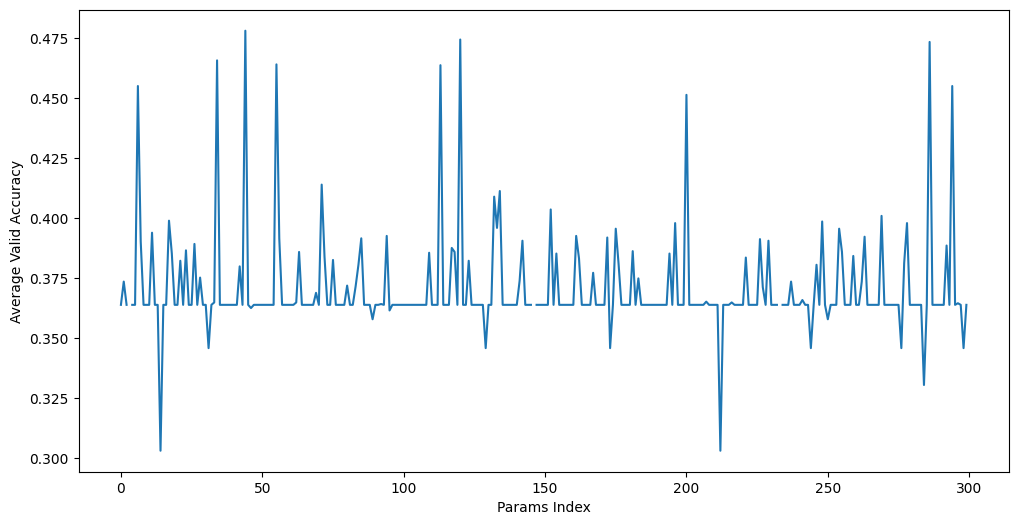

In [ ]:
def visualize_model(grid_obj):
  scores = grid_obj.cv_results_['mean_test_score']     # Get the mean cv scores for each param setting
  best_score = grid_obj.best_score_                    # max cv score
  best_param = grid_obj.best_params_                   # best param

  import matplotlib.pyplot as plt
  plt.figure(figsize = (12, 6))
  plt.plot(scores)                                     # a line plot
  plt.xlabel('Params Index')
  plt.ylabel('Average Valid Accuracy')
  #plt.title('Sentiment Classification:\n Best params = {}; \n Best CV Score : {:.3f}'.format(best_param, best_score));

visualize_model(random_search1)

In [ ]:
import pickle

with open('/content/drive/MyDrive/Capstone/best1_3class.pkl' , 'wb') as out:
  pickle.dump(best1, out)


##  2.2 Latent topics as features

In the following section, we extract the latent topics with ``Latent Semantic Analysis`` and ``Latent Dirichlet Allocation`` models, and use those latent topics as features for sentiment prediction.  

We compared ``RandomForestClassifier``, ``GaussianNB``, ``SVC`` as well as ``LogisticRegression`` models, together with different pre-processing steps with different features.




**RandomizedSearchCV**


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression


# Define the pipeline
pipe2 = Pipeline([('feature', TfidfVectorizer()),
                   ('topic', TruncatedSVD()),
                   ('scaler', StandardScaler()),
                   ('classifier', RandomForestClassifier())])

# LDA can only take tf
param1 = {'feature': [CountVectorizer()],
          'feature__ngram_range':[(1,2),(1,3),(1,4),(1,5)],
          'feature__max_df': [0.7, 0.75, 0.8, 0.85, 0.9],
          'topic': [LatentDirichletAllocation()],
          'topic__n_components': [10, 20, 30, 40, 50],
          'scaler':[StandardScaler(), MinMaxScaler(), None],
          'classifier': [GaussianNB()]}

param2 = {'feature': [CountVectorizer()],
          'feature__ngram_range':[(1,2),(1,3),(1,4),(1,5)],
          'feature__max_df': [0.7, 0.75, 0.8, 0.85, 0.9],
          'topic': [LatentDirichletAllocation()],
          'topic__n_components': [10, 20, 30, 40, 50],
          'scaler':[StandardScaler(), MinMaxScaler(), None],
          'classifier':[RandomForestClassifier(random_state = 1)],
          'classifier__n_estimators':range(1,101,10),             # more trees, more complicated model
          'classifier__max_samples':np.arange(0.01,1,0.2),        # % bootstraped sample/training data size
          'classifier__min_samples_leaf':range(5,300,20)}

param3 = {'feature':[CountVectorizer()],
          'feature__ngram_range':[(1,2),(1,3),(1,4),(1,5)],
          'feature__max_df': [0.7, 0.75, 0.8, 0.85, 0.9],
          'topic': [LatentDirichletAllocation()],
          'topic__n_components': [10, 20, 30, 40, 50],
          'scaler':[StandardScaler(), MinMaxScaler(), None],
          'classifier':[SVC(max_iter = 10000)],
          'classifier__kernel':['linear', 'poly'],
          'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 500,1000],
          'classifier__degree':range(1,10,3)}

# LSA can take either tf or tfidf
param4 = {'feature':[CountVectorizer(), TfidfVectorizer()],
          'feature__ngram_range':[(1,2),(1,3),(1,4),(1,5)],
          'feature__max_df': [0.7, 0.75, 0.8, 0.85, 0.9],
          'topic': [TruncatedSVD()],
          'topic__n_components': [10, 20, 30, 40, 50],
          'scaler':[StandardScaler(), MinMaxScaler(), None],
          'classifier': [GaussianNB()]}

param5 = {'feature':[CountVectorizer(), TfidfVectorizer()],
          'feature__ngram_range':[(1,2),(1,3),(1,4),(1,5)],
          'feature__max_df': [0.7, 0.75, 0.8, 0.85, 0.9],
          'topic': [TruncatedSVD()],
          'topic__n_components': [10, 20, 30, 40, 50],
          'scaler':[StandardScaler(), MinMaxScaler(), None],
          'classifier':[RandomForestClassifier(random_state = 1)],
          'classifier__n_estimators':range(1,101,10),
          'classifier__max_samples':np.arange(0.01,1,0.2),
          'classifier__min_samples_leaf':range(5,300,20)}

param6 = {'feature':[CountVectorizer(), TfidfVectorizer()],
          'feature__ngram_range':[(1,2),(1,3),(1,4),(1,5)],
          'feature__max_df': [0.7, 0.75, 0.8, 0.85, 0.9],
          'topic': [TruncatedSVD()],
          'topic__n_components': [10, 20, 30, 40, 50],
          'scaler':[StandardScaler(), MinMaxScaler(), None],
          'classifier':[SVC(max_iter = 10000)],
          'classifier__kernel':['linear', 'poly'],
          'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 500, 1000],
          'classifier__degree':range(1,10,3)}

# LSA may take word embeddings as well (separate for W2V), use the Word2VecWrapper defined above
param7 = {'feature': [Word2VecWrapper()],
          'feature__vector_size': [50, 80, 100, 120, 150, 200,300, 400],
          'feature__window': [2, 5, 7, 9, 11],
          'topic': [TruncatedSVD()],
          'topic__n_components': [10, 20, 30, 40, 50],
          'scaler':[StandardScaler(), MinMaxScaler(), None],
          'classifier': [GaussianNB()]}

param8 = {'feature': [Word2VecWrapper()],
          'feature__vector_size': [50, 80, 100, 120, 150, 200,300, 400],
          'feature__window': [2, 5, 7, 9, 11],
          'topic': [TruncatedSVD()],
          'topic__n_components': [10, 20, 30, 40, 50],
          'scaler':[StandardScaler(), MinMaxScaler(), None],
          'classifier':[RandomForestClassifier(random_state = 1)],
          'classifier__n_estimators':range(1,101,10),
          'classifier__max_samples':np.arange(0.01,1,0.2),
          'classifier__min_samples_leaf':range(5,300,20)}

param9 = {'feature': [Word2VecWrapper()],
          'feature__vector_size': [50, 80, 100, 120, 150, 200,300, 400],
          'feature__window': [2, 5, 7, 9, 11],
          'topic': [TruncatedSVD()],
          'topic__n_components': [10, 20, 30, 40, 50],
          'scaler':[StandardScaler(), MinMaxScaler(), None],
          'classifier':[SVC(max_iter = 10000)],
          'classifier__kernel':['linear', 'poly'],
          'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 500, 1000],
          'classifier__degree':range(1,10,3)}

param10 = {'feature': [Word2VecWrapper()],
          'feature__vector_size': [50, 80, 100, 120, 150, 200,300, 400],
          'feature__window': [2, 5, 7, 9, 11],
          'topic': [TruncatedSVD()],
          'topic__n_components': [10, 20, 30, 40, 50],
          'scaler':[StandardScaler(), MinMaxScaler(), None],
          'classifier':[LogisticRegression(max_iter = 10000)],
          'classifier__penalty': ['l1', 'l2', 'elasticnet'],
          'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 500,1000]}

# list all params
params2= [param1, param2, param3, param4, param5, param6, param7, param8, param9, param10]

# randomly compare 300 param settings
random_search2 = RandomizedSearchCV(estimator=pipe2, param_distributions=params2, n_iter=300, n_jobs=-1, cv=5, random_state = 42)
random_search2.fit(X_train, y_train)
print("Best params:\n{}".format(random_search2.best_params_))
print("Best cross-validation score: {:.3f}".format(random_search2.best_score_))

Best params:
{'topic__n_components': 50, 'topic': TruncatedSVD(n_components=50), 'scaler': None, 'feature__window': 2, 'feature__vector_size': 400, 'feature': Word2VecWrapper(vector_size=400, window=2), 'classifier__n_estimators': 21, 'classifier__min_samples_leaf': 25, 'classifier__max_samples': 0.6100000000000001, 'classifier': RandomForestClassifier(max_samples=0.6100000000000001, min_samples_leaf=25,
                       n_estimators=21, random_state=1)}
Best cross-validation score: 0.430


In [ ]:
best2 = random_search2.best_estimator_

best2.score(X_test, y_test)

0.4174174174174174

In [ ]:
res2 = pd.DataFrame(random_search2.cv_results_)

res2.to_csv('/content/drive/MyDrive/Capstone/RSearch2_cv_3class.csv')

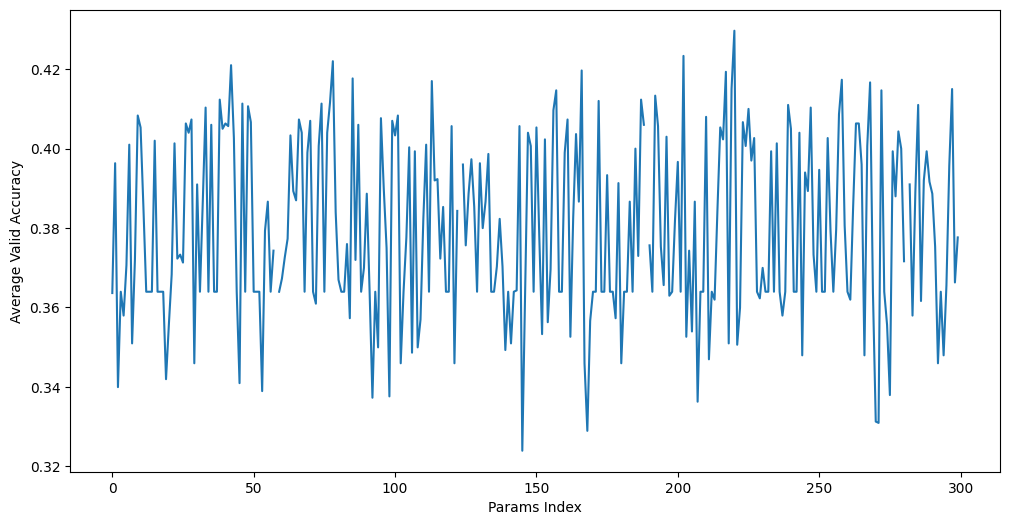

In [ ]:
# visualzie the models in random search

visualize_model(random_search2)

In [ ]:
import pickle

with open('/content/drive/MyDrive/Capstone/best2_3class.pkl' , 'wb') as out:
  pickle.dump(best2, out)

## 2.3  LSTM with text sequences as features

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)                              # tokenize the sentences
train_sequences = tokenizer.texts_to_sequences(X_train)      # turns each sentence into a sequence of numbers
test_sequences = tokenizer.texts_to_sequences(X_test)        #

word_index = tokenizer.word_index
num_unique_tokens = len(word_index)                   # total number of unique tokens: 8035
maxlen = max([len(x) for x in train_sequences])       #pad to the length of the longest individual sequence

# Pad sequence
input_train = sequence.pad_sequences(train_sequences, padding = "post", maxlen = maxlen)  # pad the sequence numbers of each token
input_test = sequence.pad_sequences(test_sequences, padding = "post",maxlen = maxlen)

display(input_train.shape, input_test.shape)

(2995, 363)

(333, 363)

In [ ]:
# Recode target for RNN

def recode_target_rnn(option):
  if option == 1:    # three-class: -1, 0, 1 recode as 0(neu), 1(pos), 2(neg) (RNN requires non-neg numbers)
    y_train2 = np.array([x if x != -1 else 2 for x in y_train])
    y_test2 = np.array([x if x != -1 else 2 for x in y_test])
  else:     # for binary task, do nothing as we've recoded it before
    y_train2 = y_train
    y_test2 = y_test
  return y_train2, y_test2

y_train2, y_test2 = recode_target_rnn(option = option)

display(np.unique(y_train2), np.unique(y_test2))

array([0, 1, 2])

array([0, 1, 2])

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# build/define the model
rnn = Sequential()

rnn.add(Embedding(input_dim=num_unique_tokens + 1,          #  input_dim: Size of the vocabulary, i.e. maximum integer index + 1.
                   input_length=maxlen,                     #  input_length:  length of input sequences
                   output_dim=128))                         #  output_dim: dimension of the dense embedding

rnn.add(LSTM(units=128,                       # dimensionality of the output space
             activation='tanh',
             recurrent_activation='sigmoid',
             dropout=0.2,                    # Fraction to drop for the linear transformation of the inputs
             recurrent_dropout=0,            # Fraction to drop for the linear transformation of the recurrent state
             unroll=False,
             use_bias=True,
             return_sequences=True))         # return the full sequence for later modeling

rnn.add(BatchNormalization())

rnn.add(Dense(units=128, activation='relu'))
rnn.add(Dropout(0.2))

rnn.add(Dense(64, activation='relu'))

rnn.add(LSTM(units=128,
             activation='tanh',
             recurrent_activation='sigmoid',
             dropout=0.2,
             recurrent_dropout=0,
             unroll=False,
             use_bias=True,
             return_sequences=False))           # return last output in the output sequence

rnn.add(BatchNormalization())

rnn.add(Dense(units=3, activation='softmax'))    # 3 classes

# build the model
optimizer = Adam(learning_rate=0.0005)            # a custom learning rate (default = 0.001)
#optimizer = RMSprop(learning_rate=0.0005)        # smaller learning rate can improve model performance
rnn.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy',  metrics=['accuracy'])     # if use one-hot encoding, use "categorical_crossentropy"

# model fitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)       # stop training if valid loss doesn't improve after 2 epochs

history = rnn.fit(input_train, y_train2, epochs=50, batch_size=32, validation_split=0.1, callbacks=[es]) # smaller batch sizes can improve the performance

Epoch 1/50
85/85 [==============================] - 130s 1s/step - loss: 1.1375 - accuracy: 0.3351 - val_loss: 1.0894 - val_accuracy: 0.4200
Epoch 2/50
85/85 [==============================] - 120s 1s/step - loss: 1.1123 - accuracy: 0.3347 - val_loss: 1.0898 - val_accuracy: 0.4200
Epoch 3/50
85/85 [==============================] - 114s 1s/step - loss: 1.1071 - accuracy: 0.3458 - val_loss: 1.0886 - val_accuracy: 0.4200
Epoch 4/50
85/85 [==============================] - 123s 1s/step - loss: 1.1013 - accuracy: 0.3536 - val_loss: 1.0867 - val_accuracy: 0.4200
Epoch 5/50
85/85 [==============================] - 122s 1s/step - loss: 1.1008 - accuracy: 0.3291 - val_loss: 1.0933 - val_accuracy: 0.4200
Epoch 6/50
85/85 [==============================] - 123s 1s/step - loss: 1.0994 - accuracy: 0.3481 - val_loss: 1.0870 - val_accuracy: 0.4200
Epoch 6: early stopping


In [ ]:
rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 363, 128)          1028608   
                                                                 
 lstm_4 (LSTM)               (None, 363, 128)          131584    
                                                                 
 batch_normalization_4 (Bat  (None, 363, 128)          512       
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 363, 128)          16512     
                                                                 
 dropout_2 (Dropout)         (None, 363, 128)          0         
                                                                 
 dense_7 (Dense)             (None, 363, 64)           8256      
                                                      

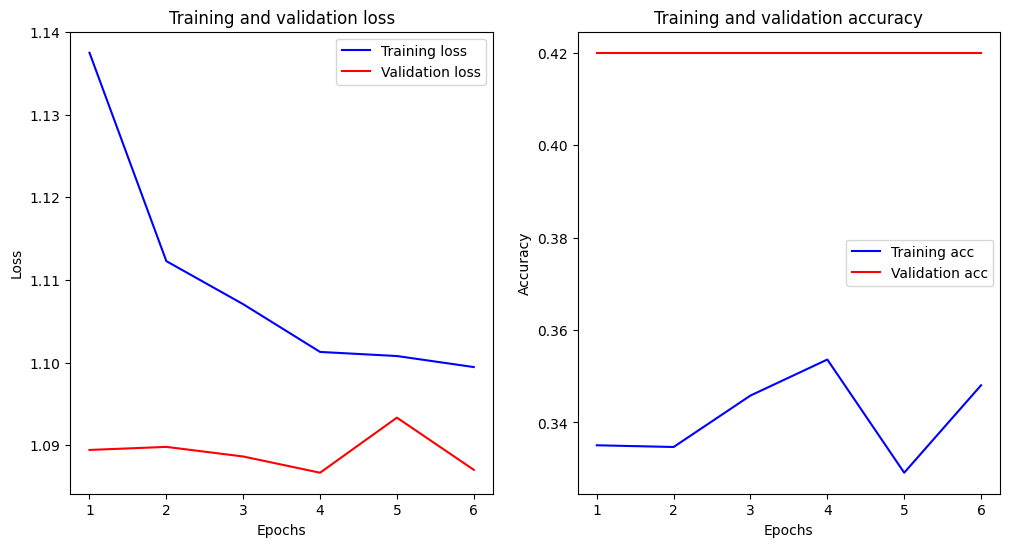

In [ ]:
def classifier_performance_plot(data):
  loss = data["loss"]
  val_loss = data["val_loss"]
  acc = data["accuracy"]
  val_acc = data["val_accuracy"]
  epochs = np.arange(1, len(loss) + 1)    # 1,2,..20

  import matplotlib.pyplot as plt
  fig, axes = plt.subplots(1,2, figsize = (12, 6))
  axes[0].plot(epochs, loss, "b-", label="Training loss")
  axes[0].plot(epochs, val_loss, "r-", label="Validation loss")
  axes[0].set_title("Training and validation loss")
  axes[0].set_xlabel("Epochs")
  axes[0].set_ylabel("Loss")
  axes[0].legend()

  axes[1].plot(epochs, acc, "b-", label="Training acc")
  axes[1].plot(epochs, val_acc, "r-", label="Validation acc")
  axes[1].set_title("Training and validation accuracy")
  axes[1].set_xlabel("Epochs")
  axes[1].set_ylabel("Accuracy")
  axes[1].legend();

history_dict = history.history      # a dictionary with four keys: 'loss', 'accuracy', 'val_loss', 'val_accuracy'
classifier_performance_plot(history_dict)

In [ ]:
import pickle

with open('/content/drive/MyDrive/Capstone/rnn_3class.pkl' , 'wb') as out:
  pickle.dump(rnn, out)

In [ ]:
# Check test performance

test_loss, test_acc = rnn.evaluate(input_test, y_test2)      # Computation in batches (default size 32)

11/11 [==============================] - 4s 327ms/step - loss: 1.0817 - accuracy: 0.4505


In [ ]:
# Alternaitvely, make predictions on test
probs = rnn.predict(input_test)     # get probabilities

y_pred = probs.argmax(axis=-1)      # return the index of max value on each row

from sklearn.metrics import classification_report
print(classification_report(y_true = y_test2, y_pred = y_pred, target_names= ['neutral', 'positive', 'negative']))

11/11 [==============================] - 6s 574ms/step
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00        82
    positive       0.45      1.00      0.62       150
    negative       0.00      0.00      0.00       101

    accuracy                           0.45       333
   macro avg       0.15      0.33      0.21       333
weighted avg       0.20      0.45      0.28       333



# 3. Apply the best model for prediction

Get the best model.

In [ ]:
import pickle

with open('/content/drive/MyDrive/Capstone/best1_3class.pkl', 'rb') as f:
  best_model = pickle.load(f)


Make predictions on unlabeled data,   concatenate the predicted and labeled data togther, save them for next stage.

In [ ]:
import pandas as pd
import numpy as np

labeled_full= pd.read_excel('/content/drive/MyDrive/Capstone/Labeled/labeled2008-2009.xlsx')
labeled_full = labeled_full[['subreddit', 'author', 'body', 'created_utc', 'id', 'parent_id', 'link_id', 'sentiment label','year']] # key 9 columns

years = range(2008,2020)
for year in years:
  # get labeled data for each year
  labeled = labeled_full[labeled_full['year'] == year]

  # get unlabeled data first
  df = pd.read_csv('/content/drive/MyDrive/Capstone/Data/' + str(year) + '_revised.csv', lineterminator='\n', index_col = 0, low_memory = False)
  df = df[['subreddit', 'author', 'body', 'created_utc', 'id', 'parent_id', 'link_id']]   # keep 7 columns
  unlabeled = df[~df['id'].isin(labeled['id'])]    # unlabeled rows are rows that the id value do NOT match

  # pre-process unlabeled data and make predictions
  unlabeled = data_clean(unlabeled)                                     # clean the data
  unlabeled['body_clean'] =  unlabeled['body'].apply(preprocess_text)   # pre-process texts for prediction
  X = unlabeled['body_clean'].to_list()
  unlabeled['sentiment label'] = best_model.predict(X)  # save predicted sentiment
  unlabeled.drop(columns=['body_clean'],inplace=True)   # drop intermediate steps
  unlabeled['type'] = 'predicted'                       # label type

  # clean labeled data for combination
  labeled = data_clean(labeled)
  labeled = recode_target(data = labeled, option = option)   # recode y (consistent with predicted labels)
  labeled.drop(columns=['year'],inplace=True)
  labeled['type'] = 'labeled'

  # concatenate and save
  final = pd.concat([unlabeled, labeled], ignore_index=True)
  final.to_csv('/content/drive/MyDrive/Capstone/Results/sentiment' + str(year) + '.csv')
  print(year, df.shape, unlabeled.shape, labeled.shape, final.shape)

2008 (6070, 7) (5876, 9) (189, 9) (6065, 9)
2009 (52369, 7) (52012, 9) (289, 9) (52301, 9)
2010 (224311, 7) (223821, 9) (290, 9) (224111, 9)
2011 (378131, 7) (377185, 9) (290, 9) (377475, 9)
2012 (545508, 7) (543664, 9) (289, 9) (543953, 9)
2013 (578816, 7) (575959, 9) (290, 9) (576249, 9)
2014 (835012, 7) (827767, 9) (290, 9) (828057, 9)
2015 (1113242, 7) (1101741, 9) (288, 9) (1102029, 9)
2016 (1444665, 7) (1420309, 9) (283, 9) (1420592, 9)
2017 (1723269, 7) (1678938, 9) (279, 9) (1679217, 9)
2018 (1777704, 7) (1701293, 9) (277, 9) (1701570, 9)
2019 (1620552, 7) (1559147, 9) (274, 9) (1559421, 9)
